# Human Dreams Text Analysis

Hi Kagglers! This is my first Notebook on Kaggle. 

This notebook has the analysis of human dreams collected from online websites. 

Let me explain my motivation!

I happened to read Freud's theories during this lockdown and got interested in his dream analysis. 

I searched for dream datasets and was not able to find good structured ones. So I web scrapped and collected ~30000 dreams. More details about web scrapping is mentioned in the last section Dataset Preparation through Web Scraping.

Since there are no labelled datasets I performed unsupervised analysis of Named Entity Recognition, Sentiment Analysis and Topic Modelling.

Please share if you have know any labelled dreams datasets. Also, share your feedback in the comments section. 

The notebook is organised in the following order:
* Install and Import libraries
* Data Loading and Basic Exploratoty Analysis
* Dream Analysis using POS Tagging
* Named Entity Recognition
    * Overall Distribution
    * Detailed Distribution
* Sentiment Analysis
* Topic Modelling
* Data Preparation using Web Scraping

EDIT: I updated few plots using Plotly

# **Install and Import Libraries**

Installing all the required libraries for data handling, plotting, web scarping among others.

In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!pip install wordcloud
#!pip install cufflinks
import os
import re
import string
from collections import Counter, defaultdict
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')#Error loading
nltk.download('punkt')#Error loading
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import word_tokenize, pos_tag
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
import en_core_web_sm
from PIL import Image
import requests
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

import plotly.express as px

#!pip install textblob  #Error installing


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/C00219805/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/C00219805/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading BokehJS ...

Edit: I am unable to load nltk and Afinn packages in this run on Kaggle. I might be facing some proxy issues. You can run the full notebook at your end without errors. I redid it on my Jupyter notebook.


# Data Loading and Basic Exploratory Analysis

I collected the dataset by web scaraping sleepanddreamsdatabase.org. Since it took a while I saved it to a CSV file and loaded in the input folder here. But the details of web scraping are mentioned in the last section.

The Sleep and Dream Database(SDDb) contains thousands of dream reports from a wide variety of people, along with information about their sleep patterns and demographic factors like gender, age, and marital status.  

But in this analysis I used only the dreams text data. In future I plan to collect the sleep patterns and demographics as well for further analysis.

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/home/C00219805/Learning/dreams/'):#'/kaggle/input/dreams/'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename), header = 0)
        df.columns = ['id', 'text']
        print(df.head(3))
        print("Total records in dataset: {}".format(len(df)))
        

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   id                                               text
0   0  001 Nightmare in Cambodia. In the dream we are...
1   1  002 The enemy is above, in the sky. We are not...
2   2  003 We are on a firebase. It is night time. In...
Total records in dataset: 30799


There are numericals in the text for large number of dreams. These would be cleaned in the later sections.

**Basic Exploratory Data Analysis**

Identify nulls in the dataset and create any new features if required.

In [3]:
print("Nulls in Datasets: ")
print(df.isnull().sum())
df = df[df['text'].notna()]

Nulls in Datasets: 
id      0
text    3
dtype: int64


Text is our main component in this analysis.


Let us first create some meta features like word counts, unique words, stop word count, punctuation count. It might help a for more detailed analysis of dreams. 

**Creating Meta Features**

In [4]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
stop_words = set(stopwords.words('english'))
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

print(df.head(3))
df = df[df['mean_word_length'].notna()]

/home/C00219805/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


   id                                               text  word_count  \
0   0  001 Nightmare in Cambodia. In the dream we are...         141   
1   1  002 The enemy is above, in the sky. We are not...         132   
2   2  003 We are on a firebase. It is night time. In...         136   

   unique_word_count  stop_word_count  mean_word_length  char_count  \
0                 96               71          4.234043         737   
1                 99               66          4.212121         687   
2                101               67          4.323529         723   

   punctuation_count  
0                 19  
1                 23  
2                 26  


Let us plot the distributions of these meta features.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


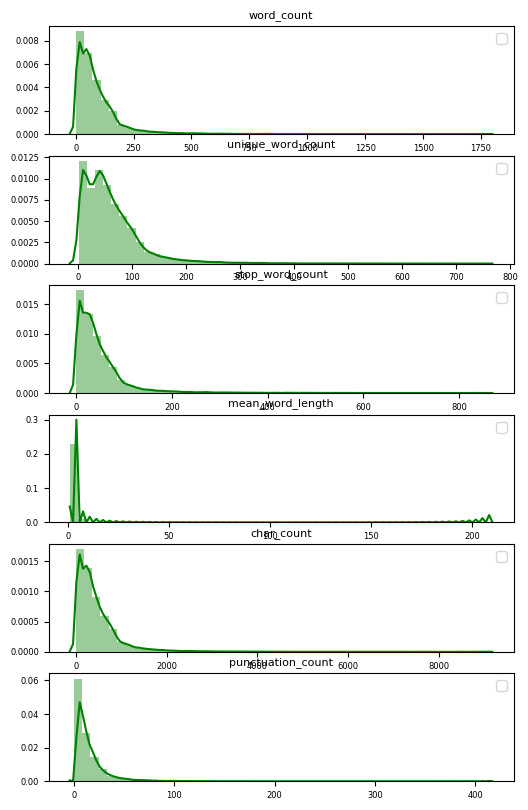

In [23]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count',  'mean_word_length', 'char_count', 'punctuation_count']
fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(6, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df[feature],ax = axes[i], color='green')    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=6)
    axes[i].tick_params(axis='y', labelsize=6)
    axes[i].legend()    
    axes[i].set_title(f'{feature}', fontsize=8)

plt.show()

We can do very eloborate analysis of these meta features in association the demographics and sleep patterns of the dreamer are available. But our focus in this notebook is to study the data in dreams. Hence we will skip it for now.

**Text Cleaning and Preprocessing**

Text processing includes removal of puntuation, numbers and converting to lower case. In certain cases lemmatized text is used for some visualizations.

In [5]:
# Utility Functions for Text Cleaning
# Import spaCy's language model
en_model = en_core_web_sm.load()
#en_model = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    '''Get lemmatized tokens.'''
    output = []
    for i in texts:
        s = [token.lemma_ for token in en_model(i)]
        output.append(' '.join(s))
    return output
def clean_text(text):
    '''Text cleaning including punctation and numbers removal.'''
    if not is_nan(text):
        text = text.lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        return text
def is_nan(x):
    '''Checks if an entity is a null value.'''
    return (x != x)

# Applying the cleaning function to text and remove records with nulls in text
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))
print(df['cleaned_text'].head(3))

0     nightmare in cambodia in the dream we are bei...
1     the enemy is above in the sky we are not sold...
2     we are on a firebase it is night time in the ...
Name: cleaned_text, dtype: object


Let us first make a Word Cloud to see what words are present in our dreams data. One can uncomment the lemmatized code line to see only lemmatized words which help in removing the redundancy in the text.

We should first prepare the text data for wordcloud generation. We can pass all the text together or we can pass words with their frequencies. Also, word clouds can be generated using image masks.

We will first define a function to create word cloud with all these alternatives.

In [6]:
def get_word_cloud_with_image(data,is_freq, title= None, image = None ):
    stopwords = set(stop_words)
    stopwords.add(".It")
    if is_freq:
        wc = WordCloud( max_words=2000, mask=image, width = 800, height = 800,
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate_from_frequencies(data)
    else:
        wc = WordCloud( max_words=2000, mask=image,
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(data)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.title('Word Cloud of {}'.format(title), size =20)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Here we will pass all the dreams text together.

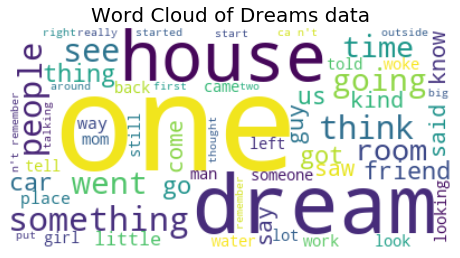

In [35]:
#Contacenate all text rows into single string
text = df['text'].str.cat(sep=' ')
tokens = word_tokenize(text)
result = [i for i in tokens if not i.lower() in stop_words]
#lemmatized_result = lemmatization(result)
all_dreams = " ".join(result)

get_word_cloud_with_image(all_dreams, False , title = 'Dreams data')

Not bad for an almost raw data. We can see that words like dream, people, house etc. 
But we cannot draw any conclusions from the above wordcloud clearly. 

EDIT: I am unable to download nltk stop words and Afinn package. The word cloud has lot of stop words in this run.

# **Generate n-Grams for Analysis**

So until now we have seen single tokens distribution in the dreams data. 

N-grams analysis might give more insights into the data. Lets perform N-gram analysis.

Let us first define a function for N-gram generation.

In [124]:
#Utility functions for n-gram generation
def get_top_n_grams(corpus, n=None, ngram = 1):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_n_grams(n, ngram= 1):
    common_words = get_top_n_bigram(df['cleaned_text'], n=n, ngram = ngram)
    df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
    df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top {} {}-grams in dreams'.format(n, ngram))

Test for Bi-grams and Tri-grams to see if we can get any better understanding.

In [106]:
N = 20
from sklearn.feature_extraction.text import CountVectorizer
plot_n_grams(N, ngram =2)
plot_n_grams(N, ngram =3)
plot_n_grams(N, ngram =4)

Now I will train a word2vec model to generate bigrams. Let us plot bigrams in a 2-D plot by using their embeddings from word2Vec and later apply it to TNSE for reduction to 2D space and plotting using Ployly.

Prepare the text to use gensim phrases package.

In [183]:
def prep_text(in_text):
    return in_text.lower().translate(str.maketrans("", "", string.punctuation)).split()
df['clean_token_text'] = df.apply(lambda row: prep_text(row['cleaned_text']), axis=1)
sentences = df.clean_token_text.values

In [184]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=1, threshold=1)
bigram = Phraser(phrases)

Testing our generated bigram model on an example

In [186]:
print(bigram[df['cleaned_text'][9].split()])

df['cleaned_text'][9]

['i_am', 'in_a', 'strange', 'sort_of', 'bunker', 'the_other', 'day', 'i_had', 'been', 'going_through', 'an_album', 'of', 'family_pictures', 'the', 'bunker_is', 'actually', 'the_bar', 'in_the', 'basement_of', 'ivy', 'street', 'i_am', 'lying_on', 'the_counter', 'in_a', 'prone_position', 'the_atmosphere', 'is', 'one_of', 'war', 'sandbags', 'and', 'timber', 'abound', 'the_sky', 'is', 'eerily', 'overcast', 'bombs', 'begin_to', 'fall', 'not', 'the_mortars', 'of', 'past_dreams', 'but_rather', 'some_kind', 'of', 'heavy_artillery', 'a_sharp', 'thunder', 'follows', 'the_initial', 'detonation', 'as_if', 'there_were', 'some_sort', 'of', 'dual', 'explosive', 'or_perhaps', 'a_new', 'barrage', 'tactic', 'i', 'throw_myself', 'over', 'and', 'fall', 'to', 'the_ground', 'cowering', 'under_the', 'counter', 'i', 'wait_for', 'the_inevitable', 'within_seconds', 'a_shell', 'crashes_down', 'upon', 'the', 'spot', 'i_had', 'occupied', 'and', 'not_too', 'hastily', 'vacated', 'debris', 'flies', 'dirt', 'clods', 'a

' i am in a strange sort of bunker the other day i had been going through an album of family pictures the bunker is actually the bar in the basement of  ivy street i am lying on the counter in a prone position the atmosphere is one of war sandbags and timber abound the sky is eerily overcast bombs begin to fall not the mortars of past dreams but rather some kind of heavy artillery a sharp thunder follows the initial detonation as if there were some sort of dual explosive or perhaps a new barrage tactic i throw myself over and fall to the ground cowering under the counter i wait for the inevitable within seconds a shell crashes down upon the spot i had occupied and not too hastily vacated debris flies dirt clods and splinters of broken wood shower down i recall the thought of being randomly lucky the dream becomes unclear at this point'

In [244]:
bigram_counter = Counter()
for key in list(itertools.chain.from_iterable(bigram[sentences])):
    if key not in stopwords.words("english") :
        if len(key.split("_")) > 1 \
        and (key.split("_")[0] not in stopwords.words("english") \
             and key.split("_")[1] not in stopwords.words("english")):
            bigram_counter[key] += 1

In [245]:
for key, counts in bigram_counter.most_common(20):
    print('{0: <20} {1}'.format(key, counts))
print(bigram_counter['in_cambodia'])

last_night           1056
even_though          514
high_school          476
another_point        400
dont_remember        380
go_back              368
living_room          310
cant_remember        306
someone_else         261
went_back            240
something_like       237
walking_around       234
dont_know            230
looked_like          226
came_back            221
years_ago            220
getting_ready        206
years_old            202
one_point            188
didnt_want           181
0


The above generated counts can be used to represent the size element in the plot for the respective bigrams.

In [187]:
import gensim
from gensim.models import phrases, word2vec
model = word2vec.Word2Vec(bigram[sentences], size=50, min_count=3, iter=20)

In [188]:
tsne = TSNE(n_components=2, random_state=11)
vocab = list(model.wv.vocab)
#vocab = bigram_counter.keys()
clf = tsne.fit_transform(model[vocab])

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y'])

tmp.head(3)

/home/C00219805/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



x          y
nightmare    17.732571  27.479740
in_cambodia  11.236134  15.213409
in_the       31.162560  16.553623

The above step takes quite sometime.

In [200]:
tmp = tmp.reset_index()
print(len(tmp))

49224


In [246]:
tmp['count'] = tmp['words'].map(bigram_counter)
tmp= tmp.fillna(0)
print(len(tmp[tmp['count'] == 0]))
#This step will eliminate unigrams, If you want to
tmp = tmp[tmp['count'] != 0]
print(len(tmp[tmp['count'] == 0]))
print(len(tmp))

23076
0
10209


Using the full bigrams will take a lot of time and also make the plot clumsy. So let us plot it forr a sample of 150 bigrams for analysis.

In [250]:
tmp1 = tmp.sample(150)
fig = px.scatter(tmp1, x='x', y='y', hover_name='words', text='words', color='words', size = 'count', size_max=45
                 , template='plotly_white', title='Bigram similarity and frequency'
                 , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

Here, high-dimensional bigrams are represented as two-dimensional representations using a dimensionality reduction technique called t-SNE. Hovering over the above plot gives you a clear picture. One can zoom in/out the plotly plots.

# Dream Analysis based on POS Tagging

In dreams we see animals, people, things, places etc. All these come under the category of nouns. 

Now let us start with analysing the Part-of-Speech tags by extracting the nouns that our dreamers are dreaming about. 

In [107]:
#Pos Tags per dream
pos_tags = df['cleaned_text'].apply(lambda x: pos_tag(word_tokenize(x)))
df['pos_tags'] = pos_tags
print(pos_tags)

0        [(nightmare, NN), (in, IN), (cambodia, NN), (i...
1        [(the, DT), (enemy, NN), (is, VBZ), (above, IN...
2        [(we, PRP), (are, VBP), (on, IN), (a, DT), (fi...
3        [(we, PRP), (are, VBP), (on, IN), (an, DT), (l...
4        [(this, DT), (time, NN), (it, PRP), (is, VBZ),...
5        [(robert, NN), (and, CC), (myself, PRP), (seem...
6        [(we, PRP), (are, VBP), (on, IN), (patrol, NN)...
7        [(we, PRP), (are, VBP), (walking, VBG), (down,...
8        [(we, PRP), (are, VBP), (on, IN), (a, DT), (tr...
9        [(i, NN), (am, VBP), (in, IN), (a, DT), (stran...
10       [(we, PRP), (are, VBP), (on, IN), (the, DT), (...
11       [(i, NNS), (have, VBP), (done, VBN), (somethin...
12       [(i, NN), (am, VBP), (in, IN), (a, DT), (hosti...
13       [(in, IN), (the, DT), (dream, NN), (i, NN), (a...
14       [(i, NN), (am, VBP), (in, IN), (basic, JJ), (t...
15       [(i, NN), (am, VBP), (with, IN), (a, DT), (fri...
16       [(there, EX), (are, VBP), (several, JJ), (of, .

So we can see that every token is assigned a POS tag. 
One can find out what each POS tag stands for from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [22]:
#Collecting all POS tags together in a list
all_tags = []
for sent in pos_tags:
    for word, tag in enumerate(sent):
        all_tags.append((word, tag))
pos_counts= Counter([ j[1] for i,j in all_tags])
print(pos_counts)
    

Counter({'NN': 544731, 'IN': 316344, 'DT': 263291, 'VBD': 210176, 'JJ': 204349, 'PRP': 163704, 'RB': 148717, 'CC': 140161, 'VB': 118676, 'VBP': 105209, 'NNS': 103202, 'VBG': 95118, 'TO': 81182, 'PRP$': 65409, 'VBZ': 55870, 'VBN': 44400, 'RP': 28744, 'MD': 20222, 'WRB': 18124, 'CD': 14629, 'EX': 12186, 'WP': 11417, 'WDT': 10335, 'NNP': 6961, 'JJR': 5040, 'RBR': 2721, 'PDT': 2550, 'JJS': 2084, 'RBS': 546, 'FW': 499, 'UH': 353, 'WP$': 107, 'NNPS': 22, "''": 4, 'POS': 1, '$': 1})


Let us plot the POS tags distribution in our dataset.

EDIT: Because the stopwords are not removed in the previous step, there is a lot of unnecessary data in this run.

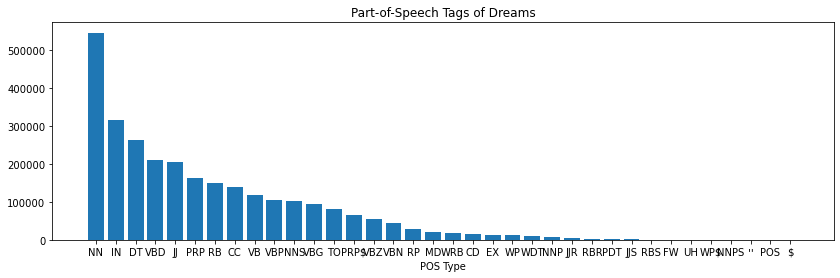

In [23]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tags of Dreams');
ax.set_xlabel('POS Type');

**Nouns Analysis**

Now we will extract only nouns from the dreams POS tags and analyse.

In [24]:
noun_counts= Counter([ j[0] for i,j in all_tags if (j[1] == 'NN') or (j[1] == 'NNP')])
print(len(noun_counts))

31407


Since there are a huge number of nouns, a bar plot will not be readable. We will again plot a Word Cloud to analyse. Here we will use the frequencies to plot the word cloud.

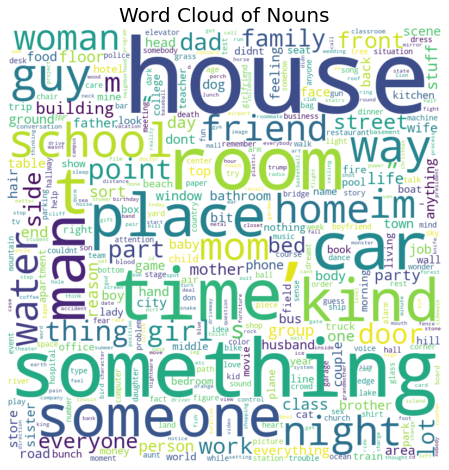

In [25]:
#Deleting 'dream' and 'i' which are highest frequency in nouns of the dreams dataset
noun_counts.pop('i', None)
noun_counts.pop('dream', None)

get_word_cloud_with_image(noun_counts,True, title= 'Nouns', image = None )

Wow! People are dreaming about places, people in their lives, in general about their life. They dream about 'house', 'room' which may indicate that they are worried about their security.They dream about school, time, girlfriend/boyfriend/friend, but definetely about 'something' or 'someone' in their 'life'.

**Adjective Analysis**

Ok now that we have seen what different objects/nouns that people are dreaming about let us see their emotions or feelings. They are nothing but the adjectives in the dreams data.

In [26]:
adj_counts= Counter([ j[0] for i,j in all_tags if (j[1] == 'JJ') or (j[1] == 'JJR') or (j[1] == 'JJS')])
print(adj_counts)

Counter({'i': 30876, 'other': 5737, 'little': 3699, '’': 3381, 'big': 3064, 'old': 2882, 'last': 2500, 'next': 2258, 'first': 1919, 'white': 1897, 'small': 1896, 'good': 1812, 'black': 1758, 'new': 1608, 'real': 1576, 'large': 1565, 'long': 1551, 'same': 1529, 'high': 1511, 'more': 1495, 'many': 1489, 'different': 1462, 'few': 1448, 'much': 1411, 'huge': 1271, 'sure': 1266, 'happy': 1228, 'bad': 1184, 'young': 1071, 's': 1067, 'right': 1008, 'able': 961, 'several': 948, 'red': 936, 'dark': 926, 'whole': 924, 'nice': 882, 'weird': 869, 'strange': 848, 'dead': 840, 't': 840, 'open': 829, 'green': 809, 'beautiful': 805, 'great': 778, 'outside': 766, '“': 743, 'im': 741, 'ready': 711, 'hard': 707, 'second': 693, 'own': 660, 'full': 647, 'angry': 617, 'cant': 596, 'blue': 590, 'sudden': 538, 'back': 533, 'afraid': 524, 'wrong': 523, 'late': 517, 'only': 505, 'best': 505, 'dont': 493, 'older': 486, 'short': 478, 'sad': 469, 'clear': 459, 'tall': 442, 'like': 442, 'most': 441, 'such': 438, 't

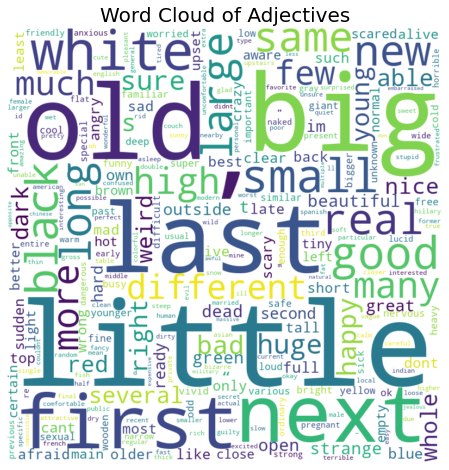

In [27]:
#Deleting 'dream' and 'i' which are highest frequency in nouns of the dreams dataset
adj_counts.pop('i', None)
adj_counts.pop('dream', None)
adj_counts.pop('other', None)

get_word_cloud_with_image(adj_counts,True, title= 'Adjectives', image = None )

Okay! We can see that there are issues of anxiety, fear, good, bad, uncomfortable, happy among many others.

Do you think just analysing nouns and adjectives is giving us a full picture?

Now-a-days, NLP is so progressed in understanding the latent information in the given text. Why not exploit that? We can perform Named-Entity Recognition, Sentiment analysis, Topic Modelling on our dreams to get deeper understanding of whats going on.

Since we do not have labelled daa, all the above mentioned tasks are perormed in an unsupervised manner.

# **Named Entity Recognition**
(Unsupervised)

Named Entity Recognition(NER) is the task of classifing named entities in the text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. It is the basic step of any Information Extraction task.

It helps us in answering the questions like who are the dreamers dreaming about, what popular companies are they dreaming about, what places etc. This totally depends on the personal experiences of the dreamers and nothing to do with the general popularity of the persons or organizations or places that show up.


In [12]:
#Loading the required package from Spacy
nlp = en_core_web_sm.load()

Let us see the raw markup for a specific dream using the displacy package after applying the Spacy's NER model.

In [13]:
displacy.render(nlp(str(df['text'].values[122])), jupyter=True, style='ent')

We can see the highlighted tokens and their respective Named Entities. More details about what each named entity represents can be found at https://spacy.io/api/annotation#named-entities

Now let us generate the named entities for all the dreams in the dataset and find out what entities people are dreaming about. 

**Overall Entity Distribution**

We will first see the overall entity distribution in our dreams and later see detailed distribution within each named entity.

In [14]:
named_entities = []
entities = []
for sent in df['text'].values:
    article = nlp(sent)
    named_entities.append([(X.text, X.label_) for X in article.ents])
    entities.append(article.ents)
print(named_entities)

[[('001', 'CARDINAL'), ('Cambodia', 'GPE'), ('American', 'NORP'), ("Jerry Bieck's", 'PERSON'), ('The next day', 'DATE'), ('Cambodia', 'GPE')], [('002', 'CARDINAL'), ('twenty yards', 'QUANTITY'), ('two', 'CARDINAL')], [('003', 'CARDINAL'), ('night', 'TIME'), ('4x7', 'WORK_OF_ART'), ('house', 'ORG'), ('fifteen', 'CARDINAL')], [('004', 'CARDINAL'), ('American', 'NORP'), ('Navy', 'ORG'), ('Crazy Frank', 'ORG'), ('WWII', 'ORG'), ('one', 'CARDINAL'), ('Vietnam', 'GPE'), ('a few more minutes', 'TIME'), ('Mortars', 'PRODUCT'), ('8 seconds', 'TIME'), ('Nam', 'DATE'), ('a few feet', 'QUANTITY'), ('a light 30', 'CARDINAL')], [('005', 'CARDINAL')], [('Robert', 'PERSON')], [('007', 'CARDINAL'), ('Nam', 'LOC'), ('4 to 5 meters', 'QUANTITY'), ('25', 'CARDINAL'), ('30 meters', 'QUANTITY'), ('Tay Ninh', 'PERSON'), ('first', 'ORDINAL'), ('two', 'CARDINAL'), ('two', 'CARDINAL'), ('three', 'CARDINAL'), ('16', 'CARDINAL'), ('105s', 'CARDINAL'), ('155s', 'CARDINAL'), ('106', 'CARDINAL'), ('first', 'ORDINAL'

In [15]:
named_entities2 = list(itertools.chain.from_iterable(named_entities))
labels = [y for x,y in named_entities2]
named_entities_counter = Counter(labels)
print(Counter(labels))

Counter({'PERSON': 24374, 'CARDINAL': 17413, 'DATE': 7082, 'ORG': 6168, 'GPE': 5504, 'TIME': 4679, 'ORDINAL': 3659, 'NORP': 2517, 'LOC': 1047, 'FAC': 865, 'WORK_OF_ART': 781, 'QUANTITY': 692, 'MONEY': 633, 'PRODUCT': 570, 'LANGUAGE': 286, 'EVENT': 162, 'LAW': 57, 'PERCENT': 47})


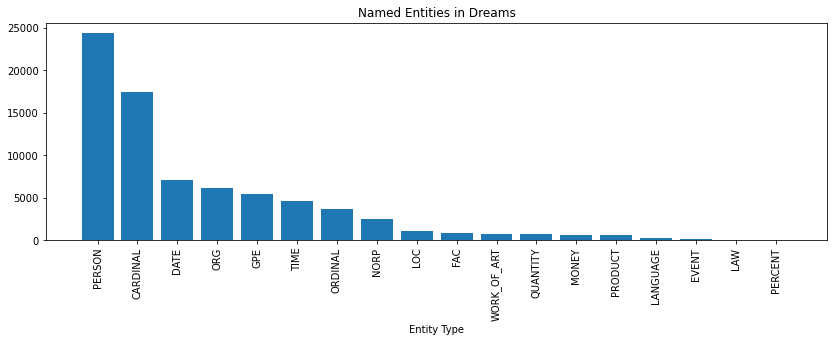

In [16]:
#Plot 
pos_sorted_types = sorted(named_entities_counter, key=named_entities_counter.__getitem__, reverse=True)
pos_sorted_counts = sorted(named_entities_counter.values(), reverse=True)

fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(named_entities_counter)), pos_sorted_counts);
ax.set_xticks(range(len(named_entities_counter)));
ax.set_xticklabels(pos_sorted_types, rotation = 'vertical', size = 10);
ax.set_title('Named Entities in Dreams');
ax.set_xlabel('Entity Type');

**Detailed Entity Distribution**

Now that we see there are lot of named entities in our data. Let us examine the top named entities of PERSON, ORGANIZATION and GPE, which indicate the entities of people, organisations and places that are in our dreams dataset. I am excluding Cardinal and dates as they do not carry much information for our analysis.

We will plot word clouds with masked images to see understand the frequencies of the entities.

In [17]:
all_entities_dict = {}
for entity_type in named_entities_counter.keys():
    words_entity_dict = {}
    for word, entity in named_entities2:
        if entity == entity_type:
            if word in words_entity_dict:
                words_entity_dict[word] += 1
            else:
                words_entity_dict[word] = 1
    all_entities_dict[entity_type] = words_entity_dict
    
#print(all_entities_dict)

{'CARDINAL': {'001': 1, '002': 1, 'two': 2621, '003': 1, 'fifteen': 7, '004': 1, 'one': 4117, 'a light 30': 1, '005': 1, '007': 1, '25': 28, 'three': 824, '16': 45, '105s': 1, '155s': 1, '106': 9, '008': 1, 'half': 297, '009': 1, '3/6': 1, '010': 3, '39': 10, '011': 1, '012': 1, '013': 1, 'Two': 234, 'One': 1011, '014': 1, '016': 1, '017': 1, 'seven': 38, 'four': 283, '020': 1, '021': 1, '022': 1, 'about fifty': 1, '023': 1, 'Thousands': 6, '024': 1, '025': 1, '2': 797, 'ten': 56, '027': 1, '155': 8, '028': 1, '029': 1, '1': 281, '35': 15, '34': 10, '68': 10, '98': 13, '86': 9, '031': 1, 'Half': 14, '033': 1, '3': 485, '4': 239, '5': 155, '6': 132, '9': 81, '7': 82, '8': 83, '034': 1, '035': 1, '036': 1, '037': 1, '038': 1, '039': 1, '040': 1, 'several one': 1, '041': 1, '042': 1, '044': 1, '’ve': 7, '045': 1, '046': 1, '047': 1, '048': 1, '049': 1, '050': 1, '051': 1, 'six': 77, '053': 1, '054': 1, '055': 1, 'less than fifteen': 1, '057': 1, '058': 1, '059': 1, '060': 1, 'only three o

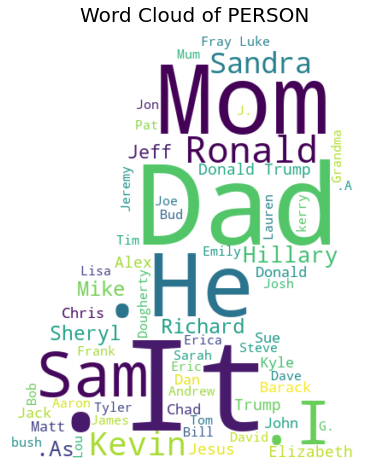

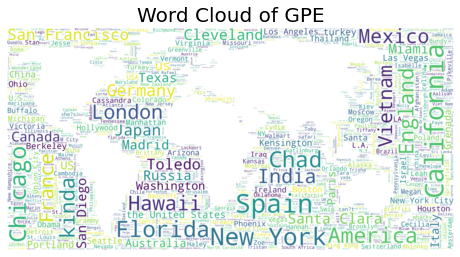

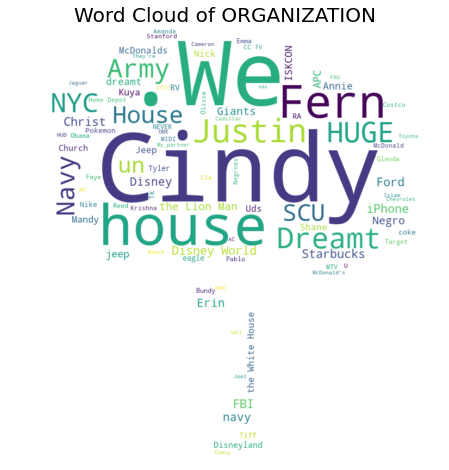

In [18]:
person_mask = np.array(Image.open("/kaggle/input/images/trump.png"))
get_word_cloud_with_image(all_entities_dict['PERSON'], True, 'PERSON', image = person_mask)

gpe_mask = np.array(Image.open("/kaggle/input/images3/world.png"))
get_word_cloud_with_image(all_entities_dict['GPE'], True, 'GPE', image = gpe_mask)

org_mask = np.array(Image.open("/kaggle/input/images2/tree.png"))
get_word_cloud_with_image(all_entities_dict['ORG'], True, 'ORGANIZATION', image = org_mask)


We can see names of people in the PERSON word clouds and all the places people are dreaming about in the GPE word cloud. These word clouds are pretty good. But we can see lot of misclassifications in the ORG word cloud.

Let us do Sentiment Analysis on the dreams and clearly find out what each dream is actually about or what is the emotion the dreamer has experienced after a dream by giving it a score.

# **Sentiment Analysis**

Since we do not have any labelled data of dreams and their sentiments, let us do an unsupervised sentiment analysis.

Unsupervised Sentiment Analysis can be done by using knowledgebases, ontologies, databases, and lexicons that have detailed information, specially curated and prepared just for sentiment analysis. We will perform an unsupervised lexicon-based approach.

There are many available lexicons which are dictionaries created for sentiments.

* AFINN lexicon
* Bing Liu’s lexicon
* MPQA subjectivity lexicon
* SentiWordNet
* VADER lexicon
* TextBlob lexicon

EDIT: I initially used AFFINN lexicon. In the latest run I am getting error installing it. 

In [104]:
# initialize afinn sentiment analyzer
#!pip install afinn
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(dream) for dream in df['cleaned_text'].values]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(df['dream']), list(df['cleaned_text']), sentiment_scores, sentiment_category]).T
df.columns = ['dream', 'cleaned_text', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.head(5)

dream  \
0  001 Nightmare in Cambodia. In the dream we are...   
1  002 The enemy is above, in the sky. We are not...   
2  003 We are on a firebase. It is night time. In...   
3  004 We are on an LZ; I am. saying good bye to ...   
4  005 This time, it is not the popping of the tu...   

                                        cleaned_text  sentiment_score  \
0   nightmare in cambodia in the dream we are bei...              4.0   
1   the enemy is above in the sky we are not sold...            -16.0   
2   we are on a firebase it is night time in the ...            -13.0   
3   we are on an lz i am saying good bye to an am...            -16.0   
4   this time it is not the popping of the tubes ...              0.0   

  sentiment_category  
0           positive  
1           negative  
2           negative  
3           negative  
4            neutral

That's cool!

Every dream has an assigned sentiment.

Let's examine few dreams manually and see if the sentiment is rightly assigned.

In [9]:
print(df[['sentiment_score','sentiment_category']].iloc[227])
print(df['dream'].values[227])
print('\n')
print(df[['sentiment_score','sentiment_category']].iloc[4])
print(df['dream'].values[4])
print('\n')
print(df[['sentiment_score','sentiment_category']].iloc[18])
print(df['dream'].values[18])

sentiment_score            -10
sentiment_category    negative
Name: 227, dtype: object
Torturers! I am in a public building I think a hospital and I am shivering in terror. I am terrified, but I don’t know why. I position myself on a couch lying down with my back against the wall for safety—People—a male and Janet promise they will not leave me alone, but they do. I notice people passing in the hall. I see the same blonde or wht. haired man pass by twice both times looking in my direction. He looks sullen and is in a wht. drs. Coat. The next scene I am being held down by a man that says he’s going to cut my fingers off. First however we must dig a line around the fireplace in the brick (?) He is using something like a lineoleum or wood cutter. I help because I think at least it will dull the blade but I can’t imagine what its for—perhaps to drain the blood off the altar. In comes another man and gets my other arm and says he is going to cut those fingers off—he also has a small tool ki

We see that certain sentiments are not rightly assigned. We can do a better job if we have labelled data and use algorithms to understand the latent information of the text. 

In [29]:
grouped = df.groupby([ 'sentiment_category']).describe().reset_index()
grouped

sentiment_category sentiment_score                                           \
                               count      mean       std   min  25%  50%  75%   
0           negative         11376.0 -4.548787  4.340567 -62.0 -6.0 -3.0 -2.0   
1            neutral          5448.0  0.000000  0.000000   0.0  0.0  0.0  0.0   
2           positive         13971.0  5.035788  5.444771   1.0  2.0  3.0  6.0   

         
    max  
0  -1.0  
1   0.0  
2  95.0

In [38]:
#!pip install plotly
df_g =pd.DataFrame({'sentiment_category':grouped['sentiment_category'], 
                    'counts': grouped['sentiment_score']['count']})
fig = px.treemap(df_g,  path=['sentiment_category'], values = 'counts',
                   title = 'Sentiment Polarity Distribution', 
                color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

The positive dreams are more compared to negative and neutral ones.

Let us plot the sentiment score distrution for further analysis.

In [21]:
fig = px.histogram(df, x="sentiment_score", title = 'Sentiment Score Distribution',  nbins=100)
fig.show()

We can hover over to see the values in the plot. 

The highest positive value is 95 and highest neagtive value is -62. We can manually examine those dreams. We can get this information from the describe() in the previous code blocks.

In [44]:
print(df[df['sentiment_score'] == -62]['dream'].values[0])
print(df[df['sentiment_score'] == 95]['dream'].values[0])

The setting is like a new television show….A guy and his five-year old daughter go into a country general store to buy things so they can set up a new house out in the forest….Before he knows it, the guy gets into a conflict with a bad guy and all his creeper relatives and friends….The bad guy, who is buying food for his cabin, has light brown hair, a cruel face, and a slight build….he is relentlessly menacing throughout the dream….At various points I have the perspective of the guy with his daughter, trying to deal with the bad guy….At first, it seems we have the possibility of friendship….It turns out that both of us went to army camp at Fort Knox, via Santa Clara University….I am happy to hear this, and I try to elicit from him a sense of a shared bond, something in common….but he just wants to manipulate, dominate….He somehow feels insulted by us, our presence, and our plans to live there….At one point there is a big stand-off, with his people aggressively threatening my people….Se

They are pretty long descriptions!

We can infact plot the frfrequent words of positive, negative and neutral dreams.

In [130]:
def generate_bar_plots_sentiment(sentiment):
    blob = list(itertools.chain.from_iterable(df[df['sentiment_category'] == sentiment]['pos_tags'].values))
    pos_df = pd.DataFrame(blob, columns = ['word' , 'pos'])
    common_words = get_top_n_grams(pos_df[(pos_df['pos'] == 'JJ') | 
                                          (pos_df['pos'] == 'JJR') | 
                                          (pos_df['pos'] == 'JJS')]['word'], n = 20, ngram = 1)
    df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])
    fig = df1.groupby('words').sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in {} sentiment'.format(sentiment))
    fig.update_layout(width=1200, height=500)
    fig.show()


In [131]:
from textblob import TextBlob
generate_bar_plots_sentiment('positive')
generate_bar_plots_sentiment('negative')
generate_bar_plots_sentiment('neutral')

We can infact try with Topic Modelling algorithms like Latent Semantic Analysis(LSA) and Latent Dirichlet Analysis(LDA) to understand the latent topics in our dreams data.

Let's start!

# **Topic Modelling**

Any topic modelling algorithms requires the words in the corpus to be represented as numerical values. The data is represented as a matrix of sentence by word matrix or aka document-term matrix format. Let's preprocess our data using the word counts as the values for each word.

In [133]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
#from bokeh.io import output_notebook
#count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
count_vectorizer = TfidfVectorizer(stop_words='english', max_features=40000)
text_sample = df['cleaned_text'].values

print('Dreams before vectorization: {}'.format(text_sample[1]))

document_term_matrix = count_vectorizer.fit_transform(text_sample)

print('Dreams after vectorization: \n{}'.format(document_term_matrix[1]))
print(document_term_matrix.shape[1])

Dreams before vectorization:  the enemy is above in the sky we are not soldiers but school children a voice from everywhere begins to warn us things are dropping seed begin to fall then i hear the faint echo of the tubes popping there is an underground bunker most of us run for the school bus the mortars are dropping close by within twenty yards the fear of realizing death is pacing through my mind we are all crowded in scared of a hit i shield my face with two paperback books all at once there is a sharp explosion i am hit though i scream for only a moment it is such a helpless feeling the concussion has shattered the teeth in my mouth and i am going into shock the dream ends here
Dreams after vectorization: 
  (0, 11984)	0.1232421009552162
  (0, 29687)	0.1419839533335835
  (0, 14452)	0.057429772980749284
  (0, 22544)	0.11725417633243544
  (0, 33952)	0.12579380882436678
  (0, 29474)	0.1752675913028759
  (0, 8375)	0.19601933897733917
  (0, 12706)	0.08451105785159996
  (0, 16094)	0.1546

Now that we have our input matrix ready we can start working with our topic modelling algorithms Latent Dirichelet Analysis(LDA).

**Latent Dirichilet Analysis**

LDA builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

Firstly define some utilty functions for generating topic names for the LDA output.

In [134]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        #print(t, np.mean(articles_in_that_topic, axis = 0))
        #articles_in_that_topic = np.vstack(articles_in_that_topic)
        
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

Let us generate at max 20 topics from our dreams using LDA. There are ways to calculate the optimum number of LDA topics. But it is not the scope of this notebook.

In [135]:
n_topics = 20

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

#LDA Model Generation
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

Generating topic names

In [136]:
terms = count_vectorizer.get_feature_names()
topic_names = []

for i, comp in enumerate(lda_model.components_):
    terms_comp = zip(terms, comp)
    #print(comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:4]#Change this number to indicate the #words you want to see per topic
    print("Topic "+str(i)+": ")
    topic = []
    for t in sorted_terms:
        topic.append(t[0])
    print(" ".join(topic))
    topic_names .append(" ".join(topic))
print(topic_names)


Topic 0: 
lottery bc recurrent winning
Topic 1: 
viet nam formation survivors
Topic 2: 
sword belongings relationships pirate
Topic 3: 
confronted applicable minecraft villagers
Topic 4: 
captured experiencing infected donkey
Topic 5: 
nightmares rarely luke vietnam
Topic 6: 
dreampt intrigued shave scuba
Topic 7: 
helpless marc meditation ford
Topic 8: 
reoccuring charlie intruder carlos
Topic 9: 
africa terry overweight dreamnt
Topic 10: 
grandmothers seldom occasionally tho
Topic 11: 
jeremy aunts obama disease
Topic 12: 
dislike coughing tux mourning
Topic 13: 
spiritual rat bounce barb
Topic 14: 
remark ireland cruising melanie
Topic 15: 
dream remember like dont
Topic 16: 
alot fragment na pokemon
Topic 17: 
aroused devotees quitting moscow
Topic 18: 
remeber cheating oclock gloomy
Topic 19: 
attempting overflowing immediate spreading
['lottery bc recurrent winning', 'viet nam formation survivors', 'sword belongings relationships pirate', 'confronted applicable minecraft villager

Now that we have trained our LDA model, let us visualize the topics for interpretability. We should first condense the multi-dimentional LDA topic matrix to 2-dimensions for visualization using TSNE.

In [137]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=800, plot_height=800)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=topic_names[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 30795 samples in 0.049s...
[t-SNE] Computed neighbors for 30795 samples in 4.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30795
[t-SNE] Computed conditional probabilities for sample 2000 / 30795
[t-SNE] Computed conditional probabilities for sample 3000 / 30795
[t-SNE] Computed conditional probabilities for sample 4000 / 30795
[t-SNE] Computed conditional probabilities for sample 5000 / 30795
[t-SNE] Computed conditional probabilities for sample 6000 / 30795
[t-SNE] Computed conditional probabilities for sample 7000 / 30795
[t-SNE] Computed conditional probabilities for sample 8000 / 30795
[t-SNE] Computed conditional probabilities for sample 9000 / 30795
[t-SNE] Computed conditional probabilities for sample 10000 / 30795
[t-SNE] Computed conditional probabilities for sample 11000 / 30795
[t-SNE] Computed conditional probabilities for sample 12000 / 30795
[t-SNE] Computed conditional probabilities for sa

We can make better decisions by calculating the optimal number of LDA topics by plotting log-likehood scores against each num_of_topics. It is not scope of this notebook.

# **Web Scrapping and Dataset Preparation**

The dataset I prepared is screpped from [sleepanddreamdatabase.org](http://sleepanddreamdatabase.org)

Below is the code I used for data scraping.

I intially had a downloaded CSV of 230 dreams from their dataset. That was initially stored in df variable and used as a sample for testing all the above tasks. Later I merged it with the scraped data. You need not worry about that step at all. You can simply use the CSV file of dreams.csv.

In [ ]:
print(len(df))
page = requests.get("http://sleepanddreamdatabase.org/dream/search?searchconstraint={}")
soup = BeautifulSoup(page.content, 'html.parser')
dreams = soup.find_all('div', class_='searchhittext')
all_dreams = [dream.get_text().replace('\n\t\t\t\t\t\t','') for dream in dreams]
all_dreams = [dream.replace('\n\t\t\t\t','') for dream in all_dreams]
all_dreams.extend(df['dream'].values)
all_dreams = list(dict.fromkeys(all_dreams))
df = pd.DataFrame({'dreams_text' :all_dreams})
df.to_csv('dreams.csv')


Another popular dreams database is http://www.dreambank.net/

There are some useful links for collecting more data and also for better understanding of dreams database.

https://dreams.ucsc.edu/Library/domhoff_2008c.html
https://www.atlasobscura.com/articles/the-stanford-doctor-s-attempt-to-build-a-bank-for-dreams

Thanks.